## Hybrid Quantum-Classical Machine Learning Algorithm for K-means Clustering








### Algorithm Steps
In this project, we will show how to build an hybrid optimization algorithm. The project consists of two parts: 1) From input data set $X$, generate, using a classical algorithm, a much smaller subset $X'$, such that $|X'| << |X|$ and 2) use Grover's Algorithm to find the clustering ($y_1,...,y_n$) that minimize the cost function
$$f(x,y) = \sum \sum ||x_i - y_j||^2 $$

The work was inspired by Algorithm 1.1 of *arXiv:2004.00026v1*.

1 - Let a data set $X$ which we want to optmize. The figure bellow illustrate it in two dimensional data.

<img src="files/image1.png" width="500" height="500">

2 - Using an offline coresets technique, we can create a much smaller subset $X'$ represented as follow

<img src="files/image2.png" width="500" height="500">

3 - Create k "centers" which will be optimized. Each coreset point has a distance from the centers, which will be stored in a proposed Quantum RAM to be accessed in superposition. Grover's Algorithm find the mininum distance, classifying each point according to the nearest center. A new center is calculated by a mean of each coordinate.

<img src="files/image3.png" width="500" height="500">

The best clustering is founded when $\sum \sum || x_i - y_j ||^2$ is the mininum.

<img src="files/image4.png" width="500" height="500">

In [1]:
#-------------------------Import the principal librarys that we will use on the program------------------------#

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as anima
import random
import networkx
import math as ma
import pandas as pd
from math import pi
from scipy.spatial import voronoi_plot_2d, Voronoi
from scipy.stats import*
import scipy.stats as stats
from sklearn import datasets
from qiskit import*
from qiskit.visualization import*
import qiskit
from qiskit import *
import numpy as np
import random
from random import choice
from qiskit.visualization import *
simulator = Aer.get_backend('qasm_simulator')


<h2> How can we build Offline Coresets?</h2>

Firstly we need to have the idea about coresets, hence we will understand why we choose this technique. Coresets is a kind of data reduction techniques, that  aims we reduce the data using the points that have a big weight,  chosen according the problem setting.

The central idea  of coresets is  that given a data set $X$. We can define coresets using a pair $( X',w)$ with $X' \in X$ and $w$ is a weight function that associated $R_{\geq{0}}$.  We can define this weight function by
    
                    
    
                       

$$\begin{equation}F_w(y) = r(y) + \sum(w(x) \times f(x,y))  \end{equation}$$                                                  

This above equation $y$ represent the model of core´s distribution that we call <b>Centroid</b>. We say that $(X',w)$ is a e-coreset if

$$|F(y) - F_w(y)|\leq \epsilon|F(y)|$$

One of the many ideas of how can we build construct coresets is the <i>Importance Sampling</i>. The idea is to calculate  the 'importance' of each Data set´s element. And this importance depend of the problem setting.
Let´s taken  $s(x)\geq 0$ and $s_{tot} = \sum{s(x)}$. Look that each point has a one importance of sampling which is quantifing using a sensitivity´s and weight´s parameter. The weight and sensitivity is given by the below equations
    
    
  


  $$\sigma(x) = \max_{y \in Y}\frac{|f(x,y)|}{|F(y)|}$$\\ $$w(x) =  \frac{n}{k}\times \frac{s_{tot}}{s(x)} $$

While directly computing even a single $\sigma(x)$ seems to already require a sum over $x$ within a max over $y$, it suffices to use any $s(x)$ satisfying $s(x)\geq \sigma(x)$ and this way we can reduce the cost of computing $s(x)$.
    
The problem that we want to solver is <b>k-means clustering problem</b>. So we might consider the function $f(x,y)$ as the distance from each dataset´s point to each centroid. The number of k centroids depends of the problem that you want to solver with k-means.

Now we are going to begin explain about each cells of code
    
 

Let´s begin with the generation of 500 points and 4 centroids

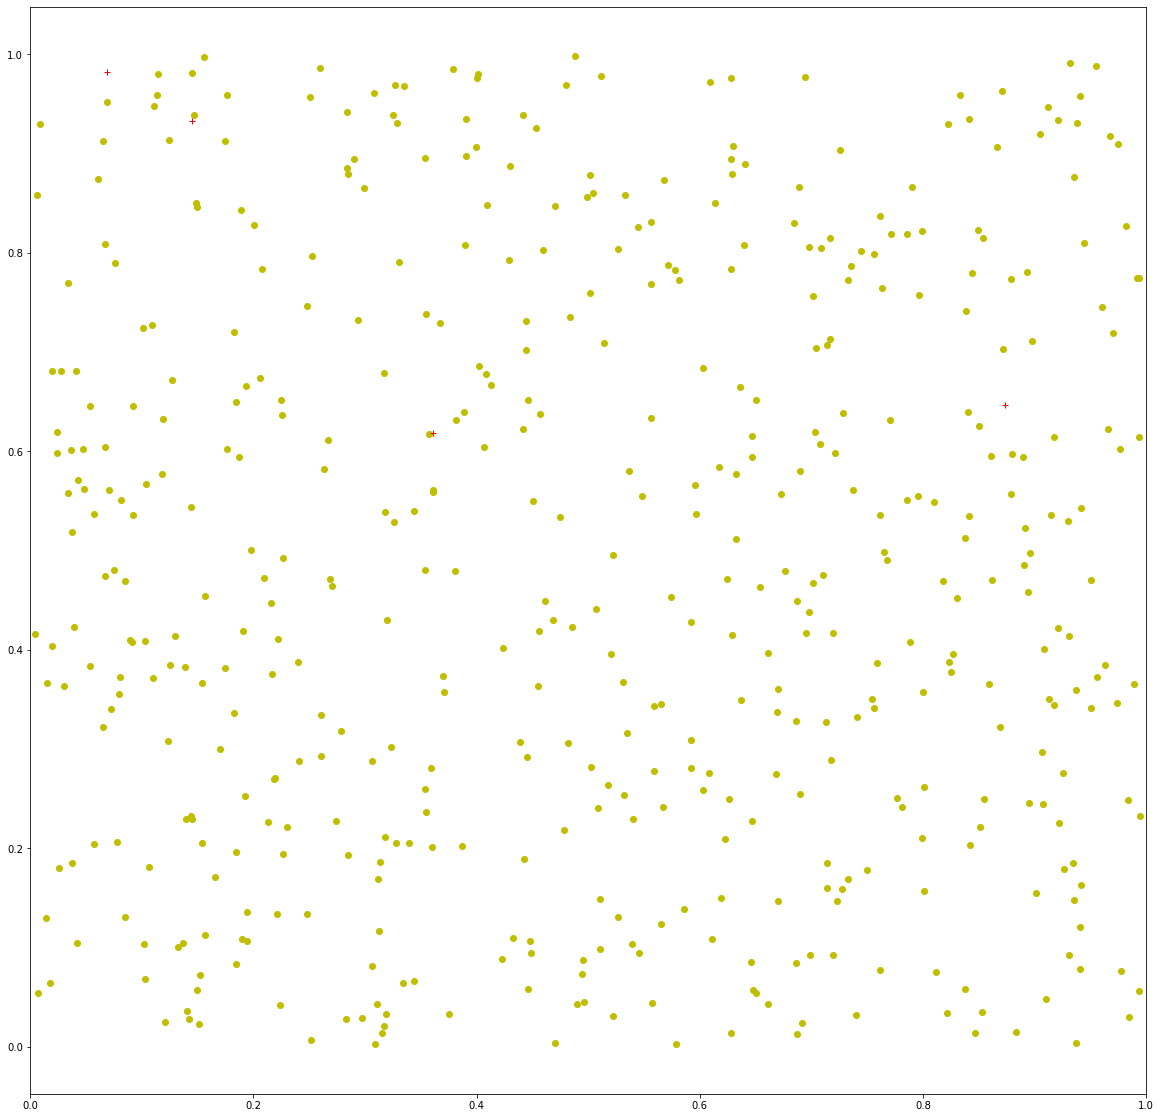

In [2]:
plt.figure(figsize=(20,20))
plt.xlim(0,1)


N= 500
x = []
y = []
generating_points = []
for i in range(N):
    x_ = random.random() # generate a random cordinate x 
    y_ =random.random()  # generate a random cordinate y   
    x.append(x_) # add a random cordinate in list x 
    y.append(y_) # add a random cordinate in list y

x__ = random.sample(x,N) # randomic chosen cordinate´s points from list x with goal to form samples
y__ = random.sample(y,N) # randomic chosen cordinate´s points from list y with goal to form samples
for i in range(N):
    generating_points.append([x__[i],y__[i]]) # generate the list of points with a randomi chosen x and randomic chosen y
    


    
plt.plot(x__,y__,'yo') #plot the points in the graph

    
    #---------------------Generate a sixteen randomic points and plot on the graph-------------------#
xc_1 =random.random()# generate a randomic cordinate x to centroid 1 
yc_1=random.random() # generate a randomic cordinate y to centroid 1
plt.plot(xc_1,yc_1,'r+') # plot of centroid in the graph


# the same subscription of the other centroids 
#-------------------------------------------------------------------
xc_2 =random.random()  
yc_2=random.random()
plt.plot(xc_2,yc_2,'r+') 
#-------------------------------------------------------------------

xc_3 =random.random()
yc_3=random.random() 
plt.plot(xc_3,yc_3,'r+')



#-------------------------------------------------------------------
xc_4 =random.random()  
yc_4=random.random() 
plt.plot(xc_4,yc_4,'r+') 

    


xc_1_ = []  
xc_1_.append(xc_1)



Now, we want found the best position of 16 centroids so let´s first calculate the distance from each point of dataset to each centroid point


$$dist = \sqrt{ (x - xc)^2 + (y - yc)^2}$$

After do this. Suppose that centroid 1 has a blue color and centroid 2 has a pink color. So if we calculate the distance from centroid 1 to some point of set x  hence we get dist1 and after that we calculate the distance from centroid 2 to the same point of set x and we get dist2. So we will compare dist1 and dist2. If dist1> dist2, the point of set x will be pink otherwise blue. When we finish of classifier the points in blue and pink, we have to counts how many points are pink and how many points are blue and after we have to sum the coordinates of blue points and divide of total blue points and the sae thing with pink points. And we gonna taken a new centroid. When we get a new centroid, we have to do the most taks, taken the distances and compare. This loop finishes when the doesn´t have change of classification points.
In code bellow we use this idea. But instead of collors we agroup in groups with name (points1_ ,points2_...points16_) with 16 centroids.


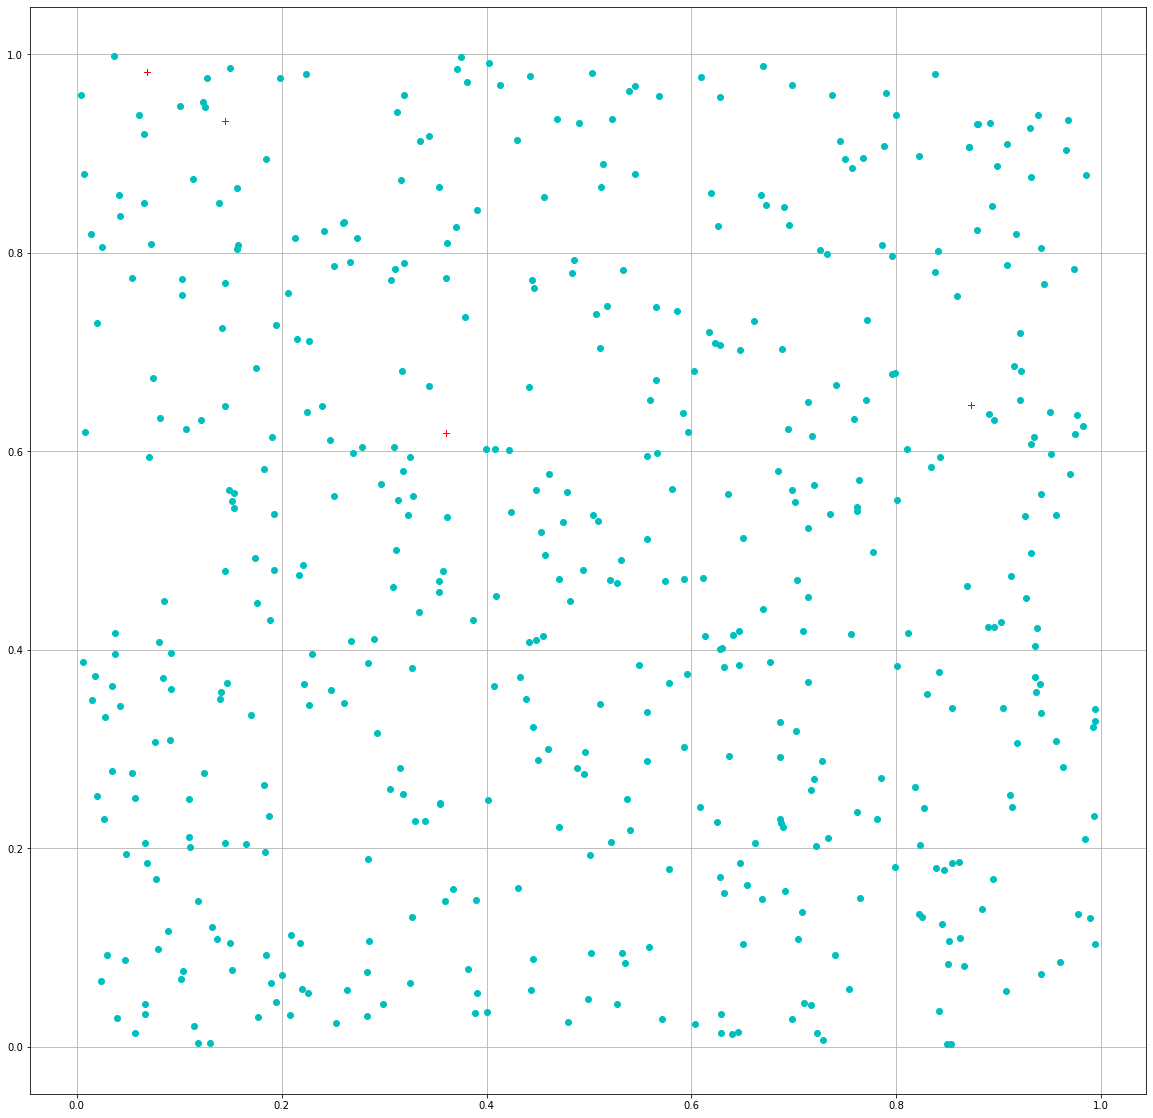

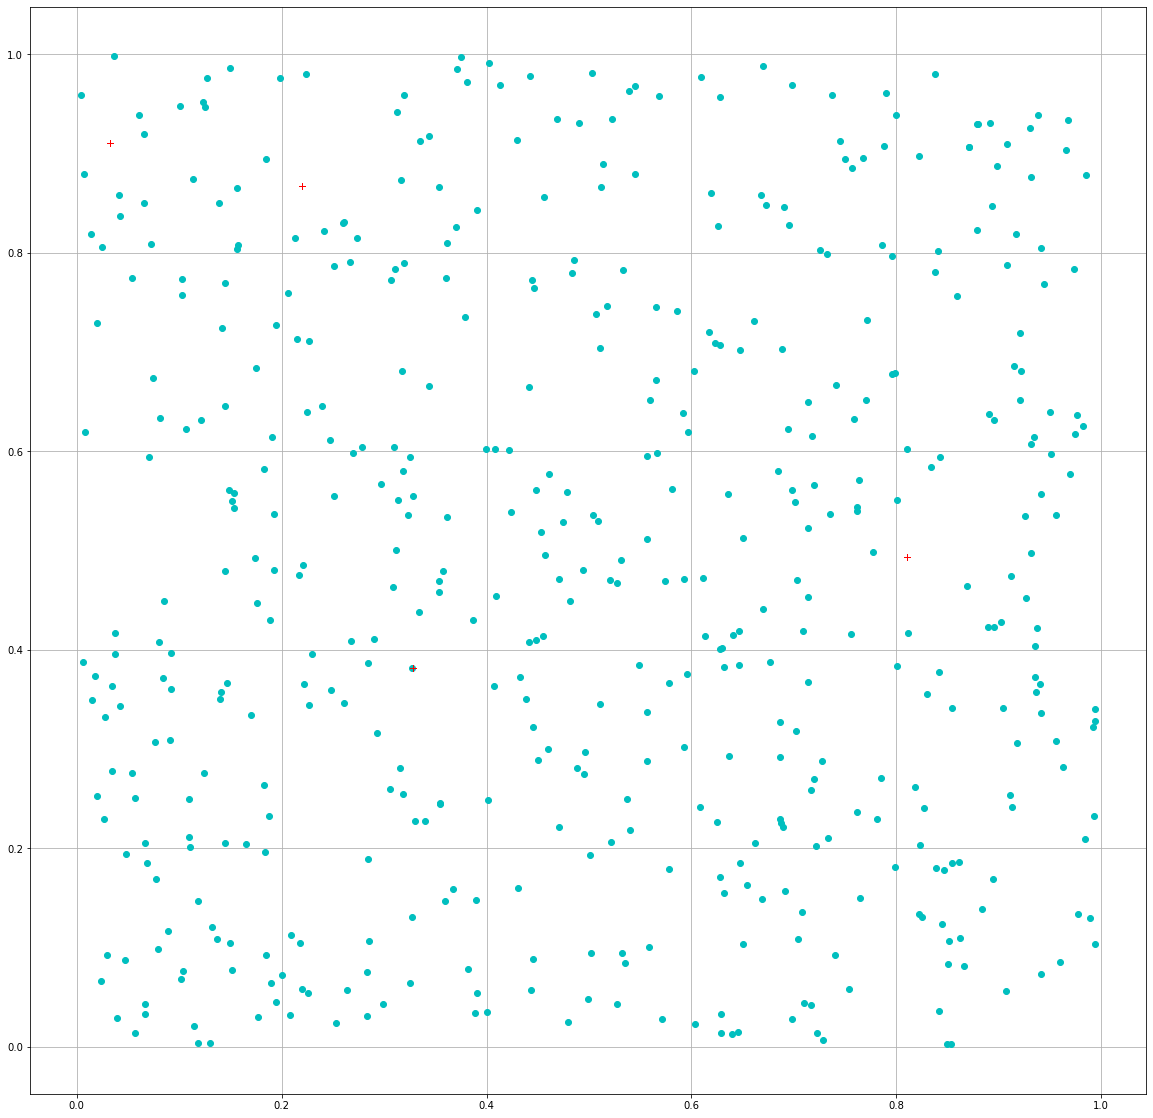

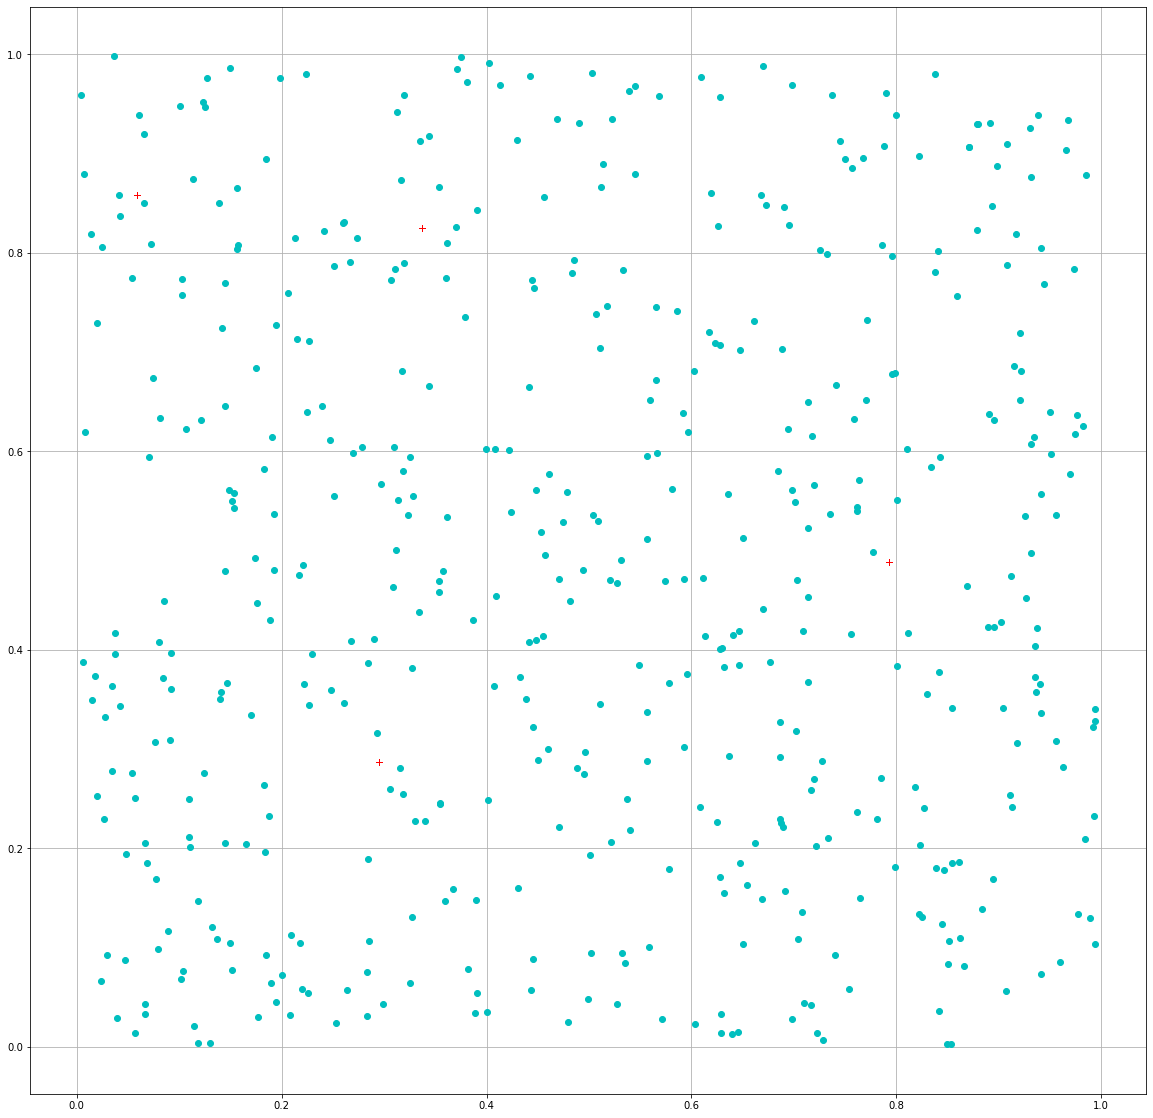

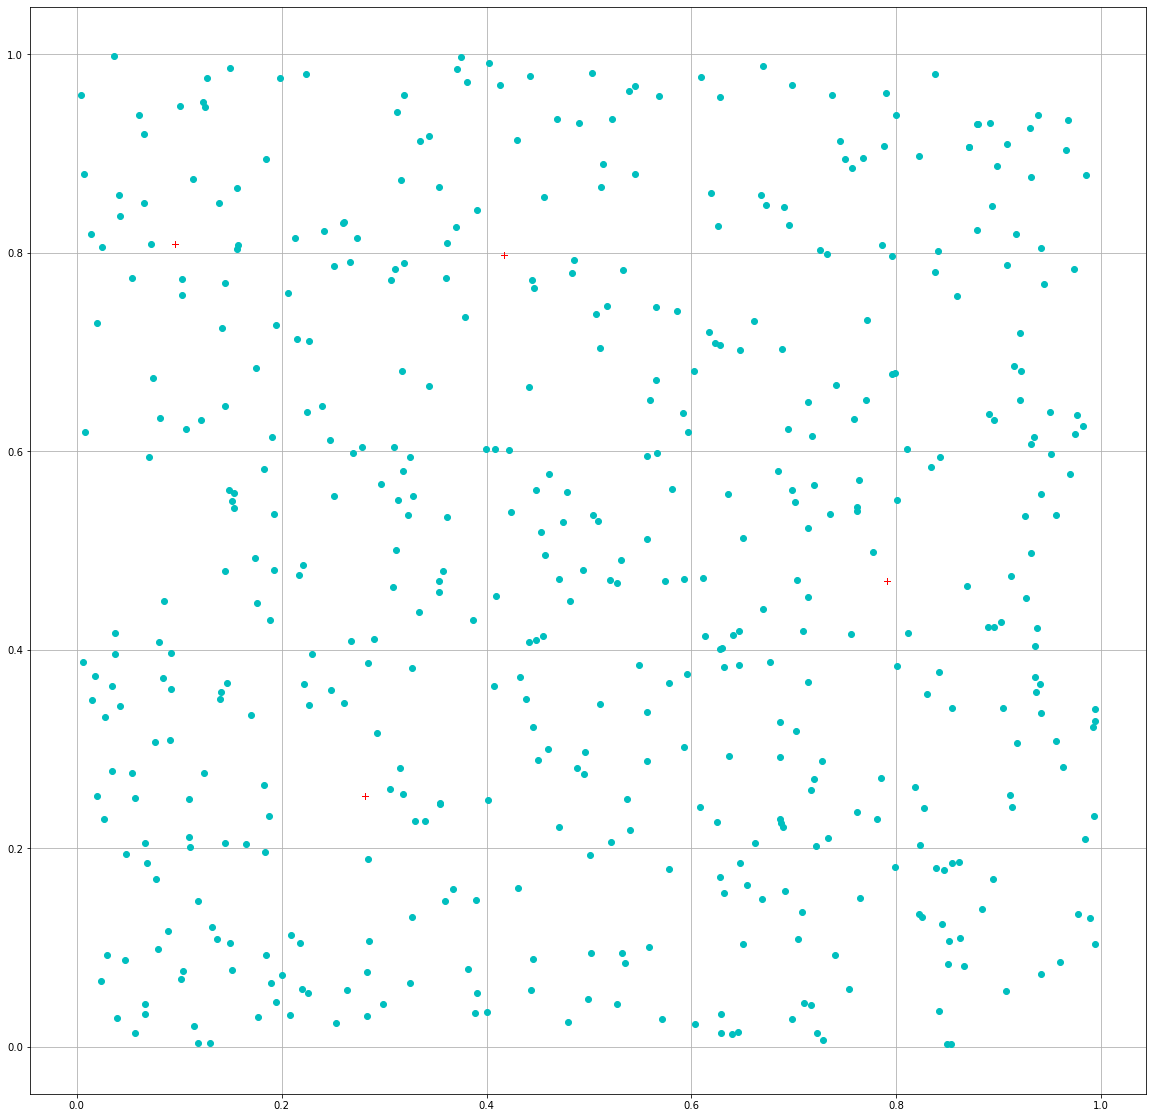

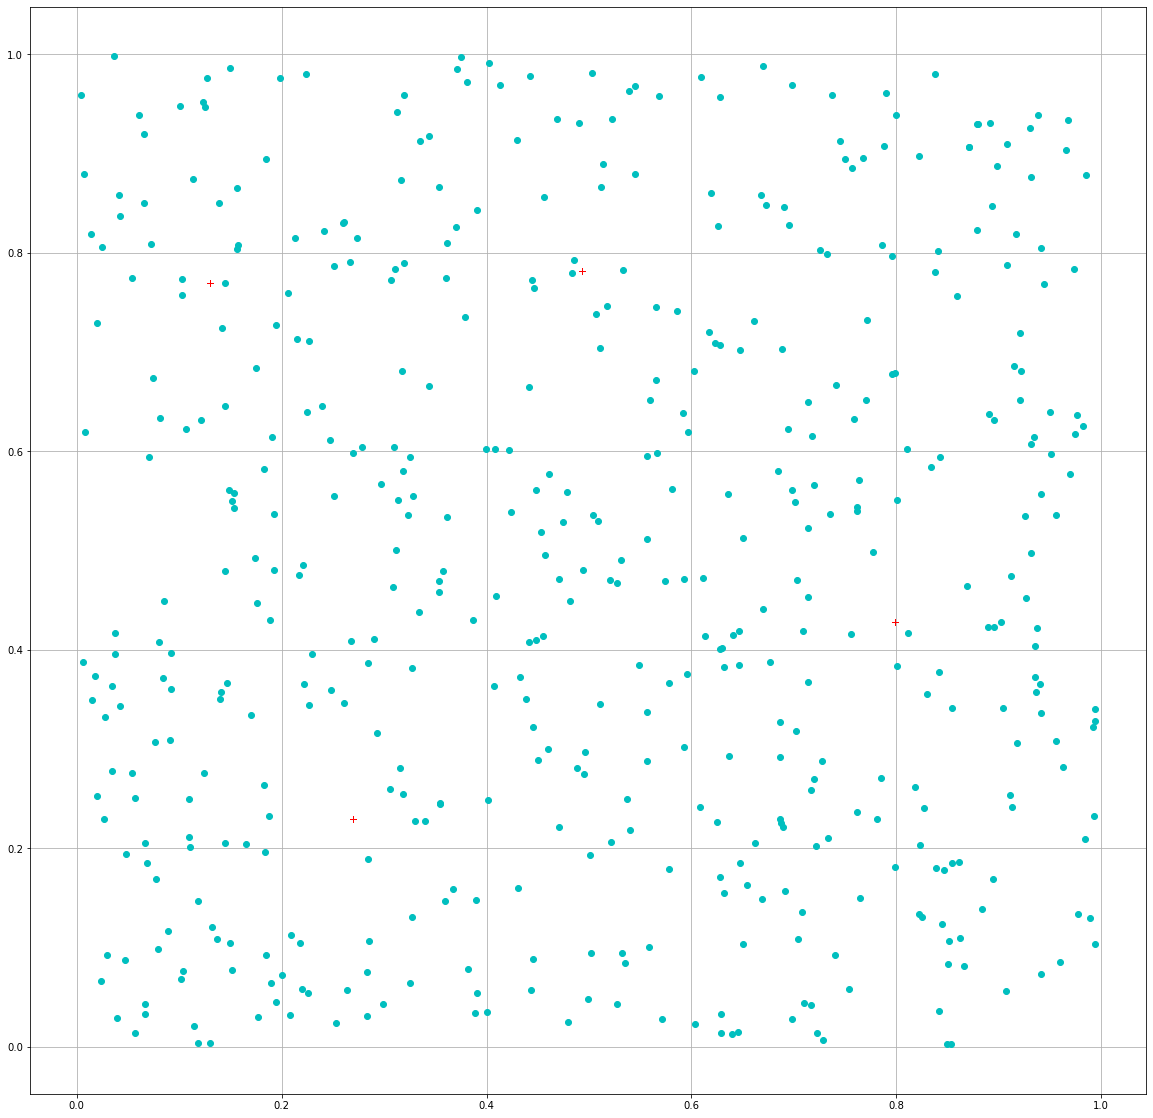

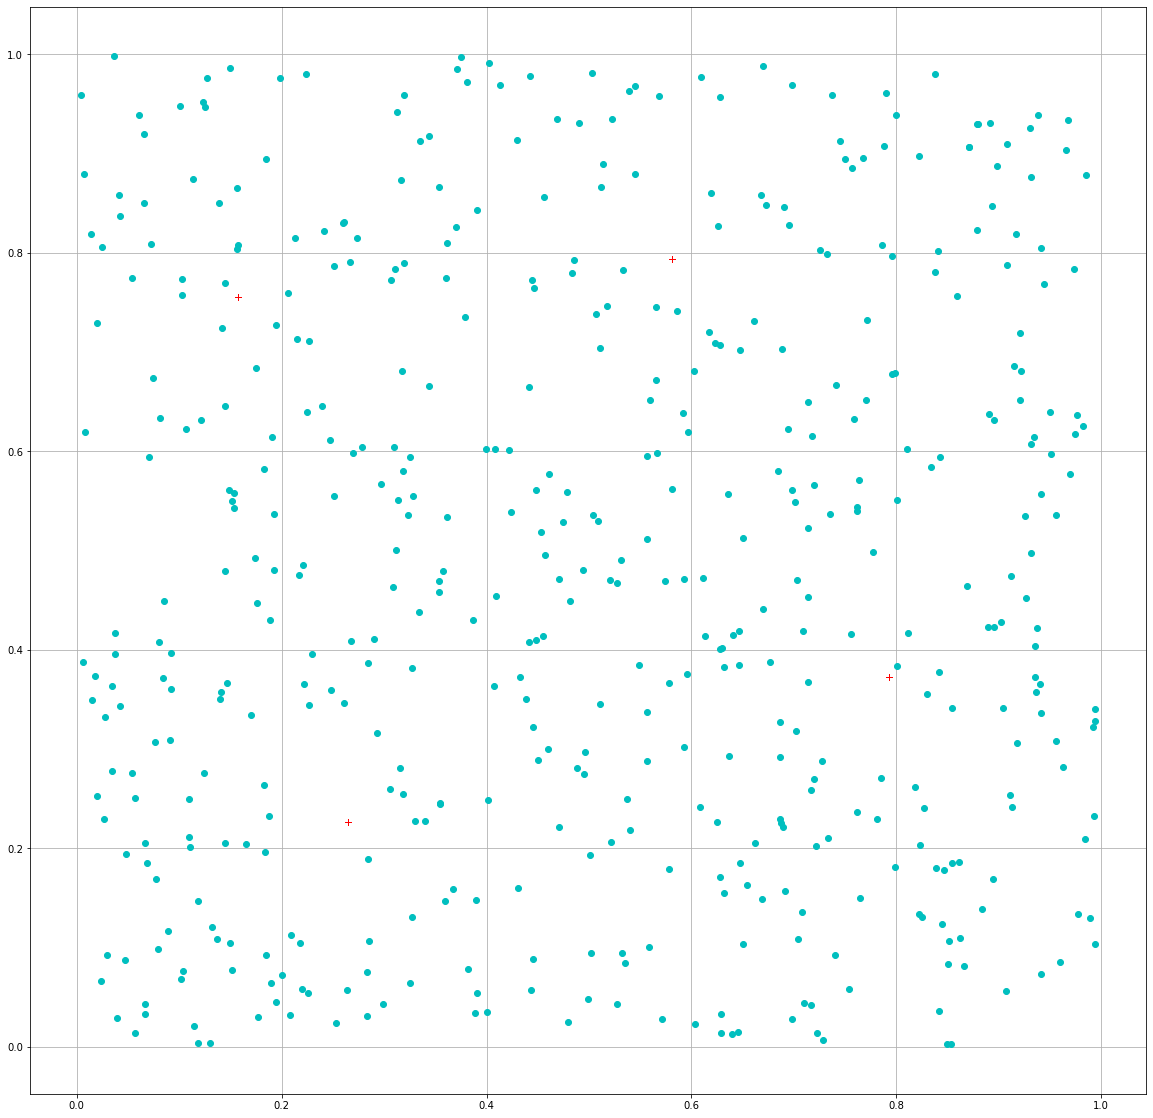

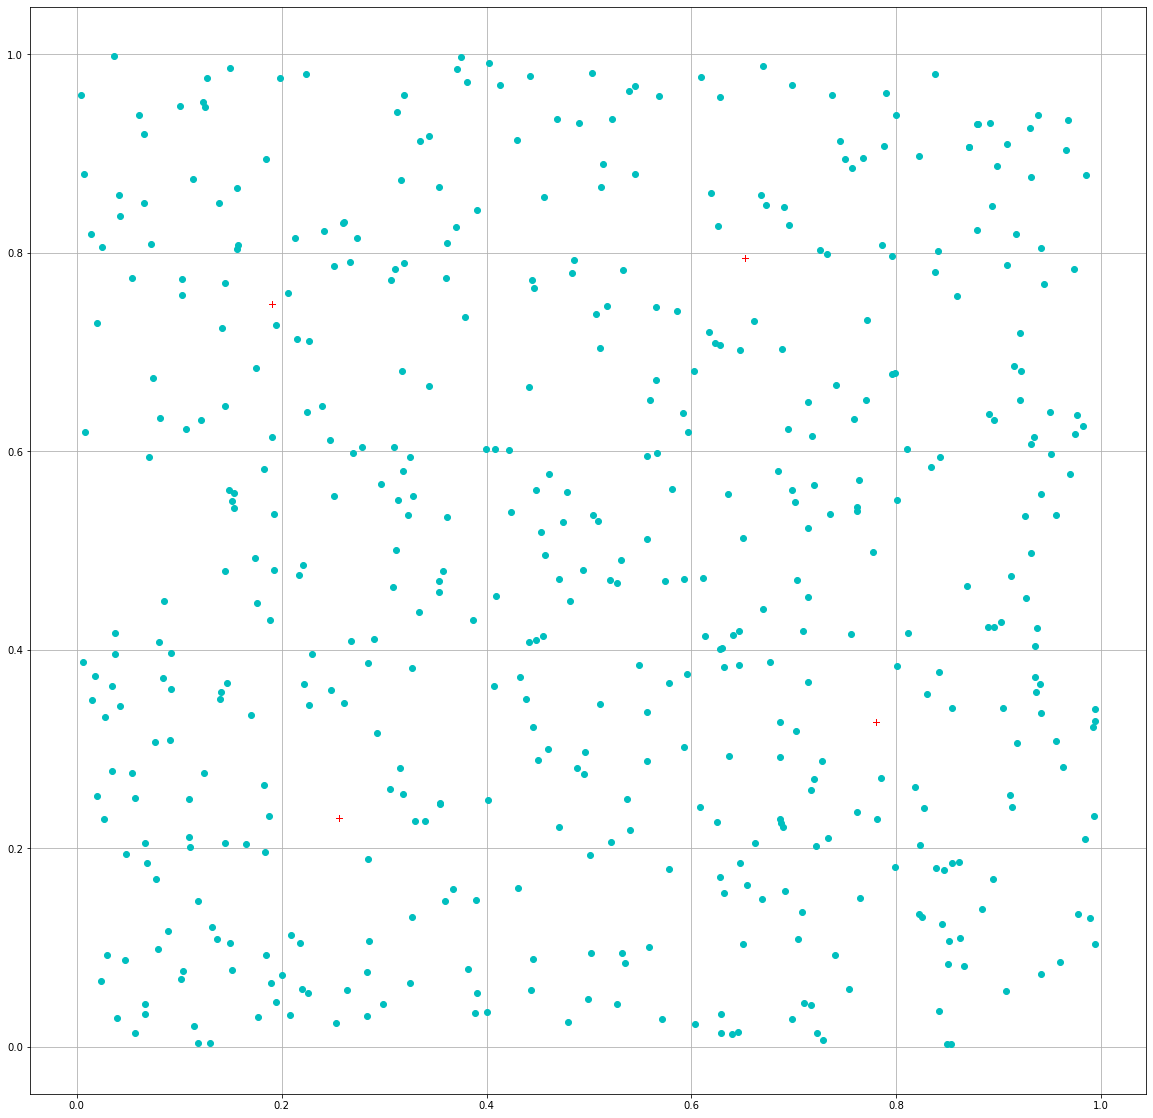

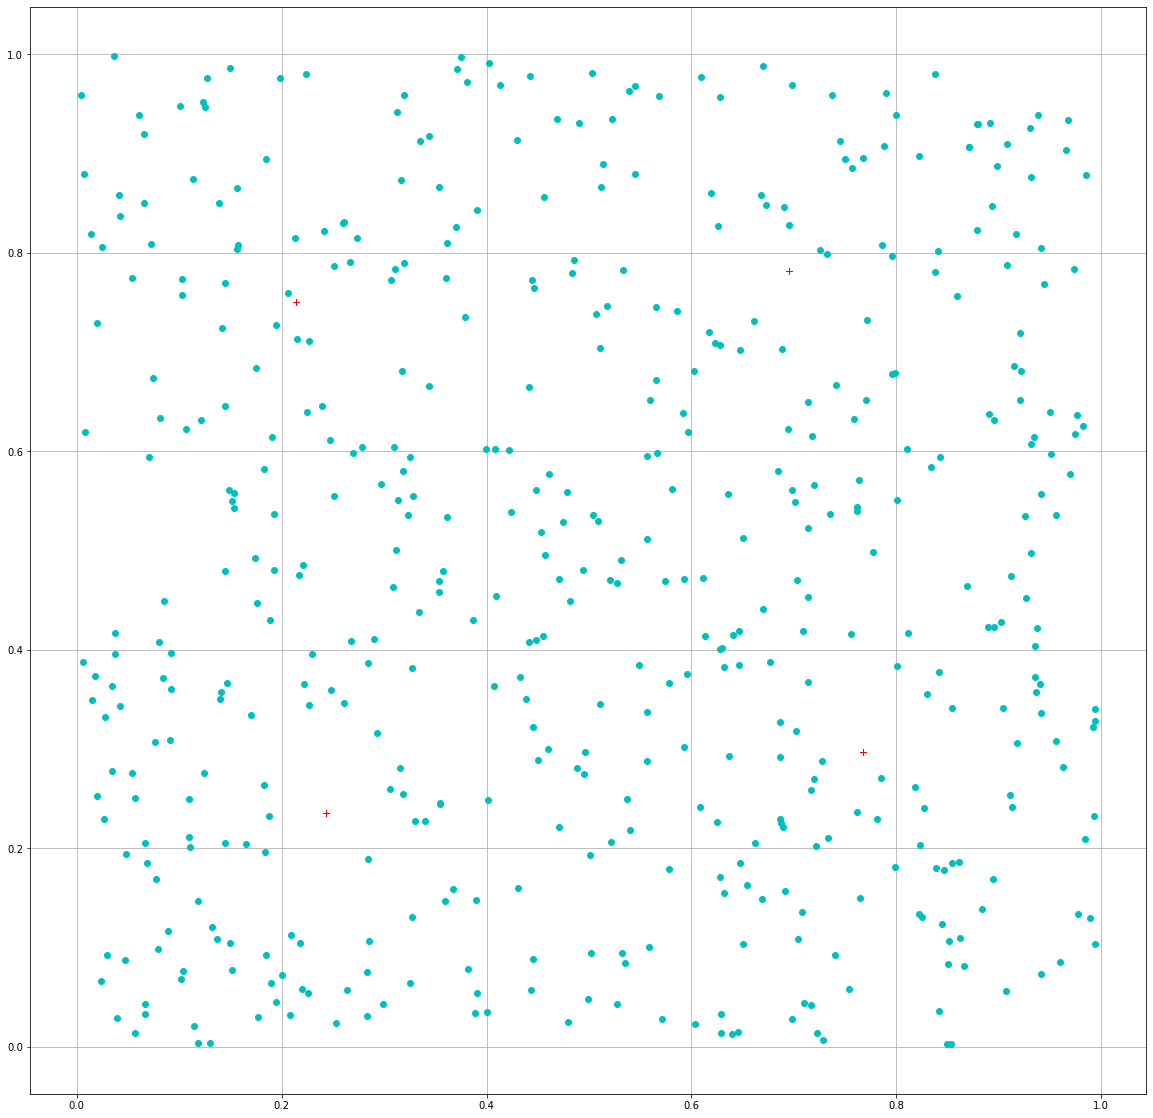

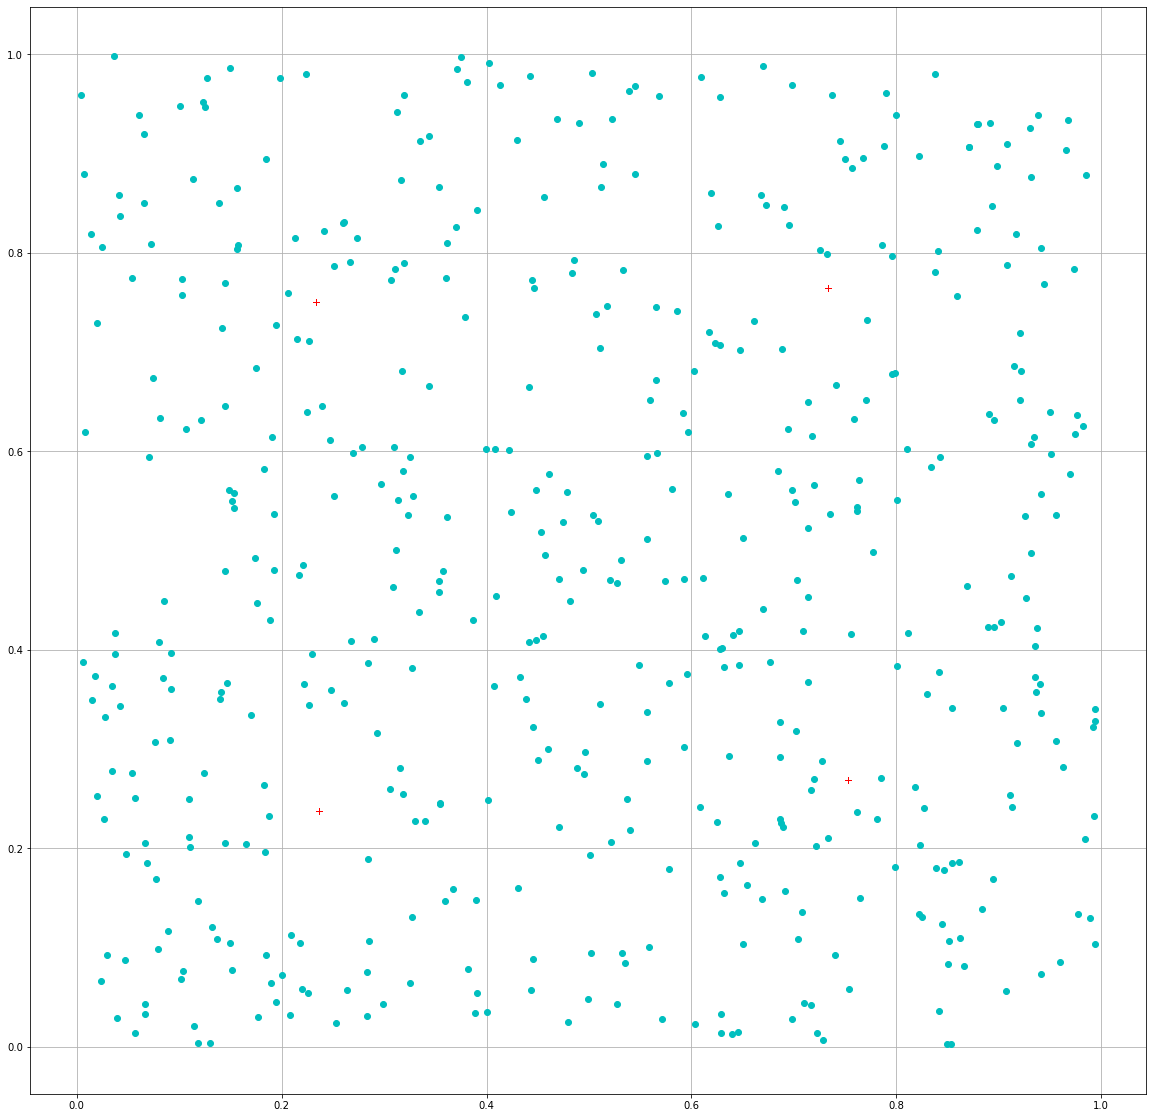

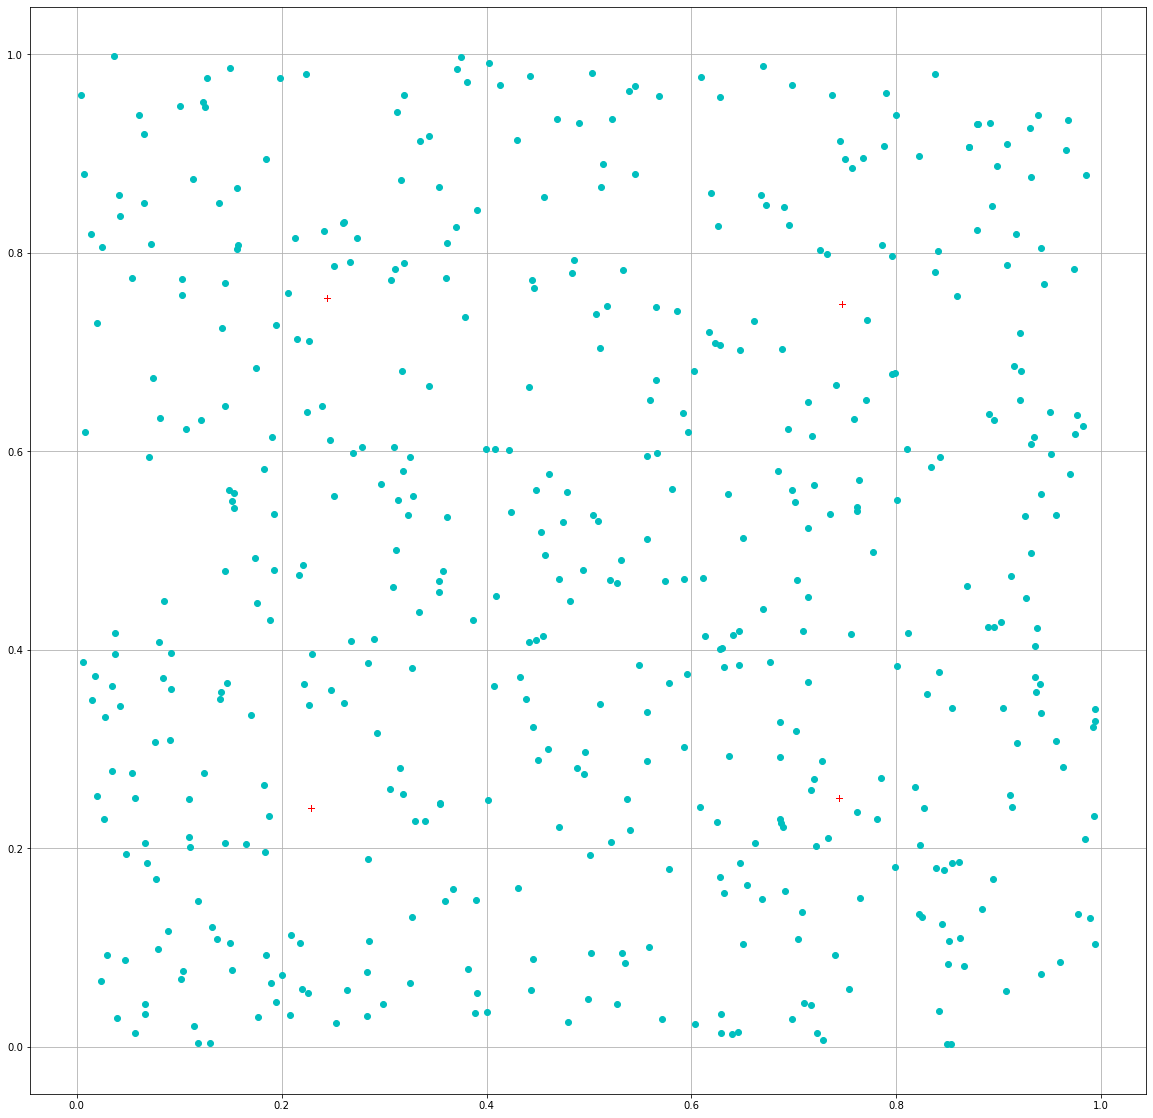

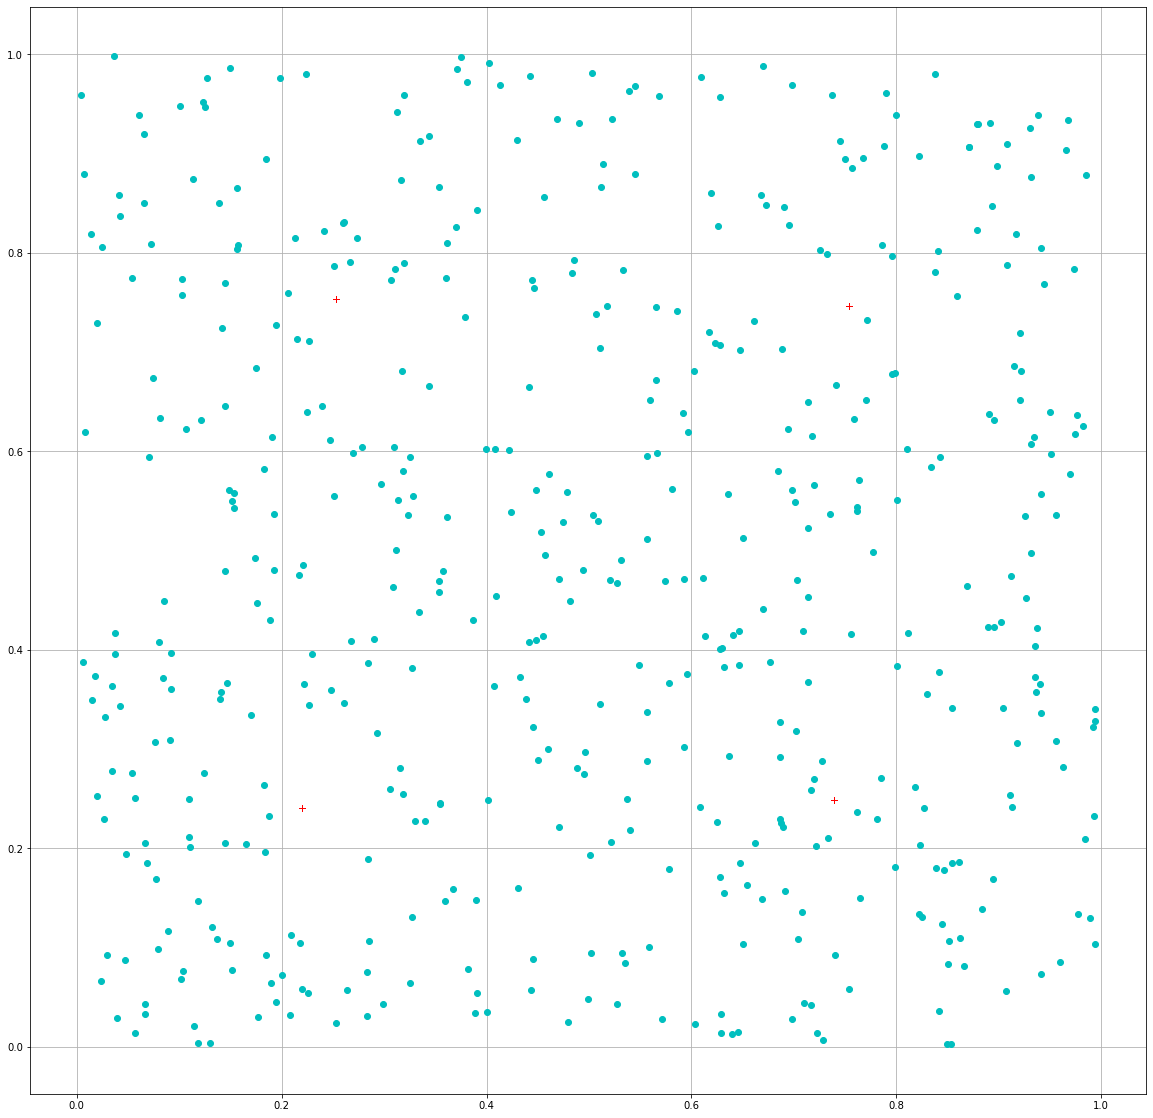

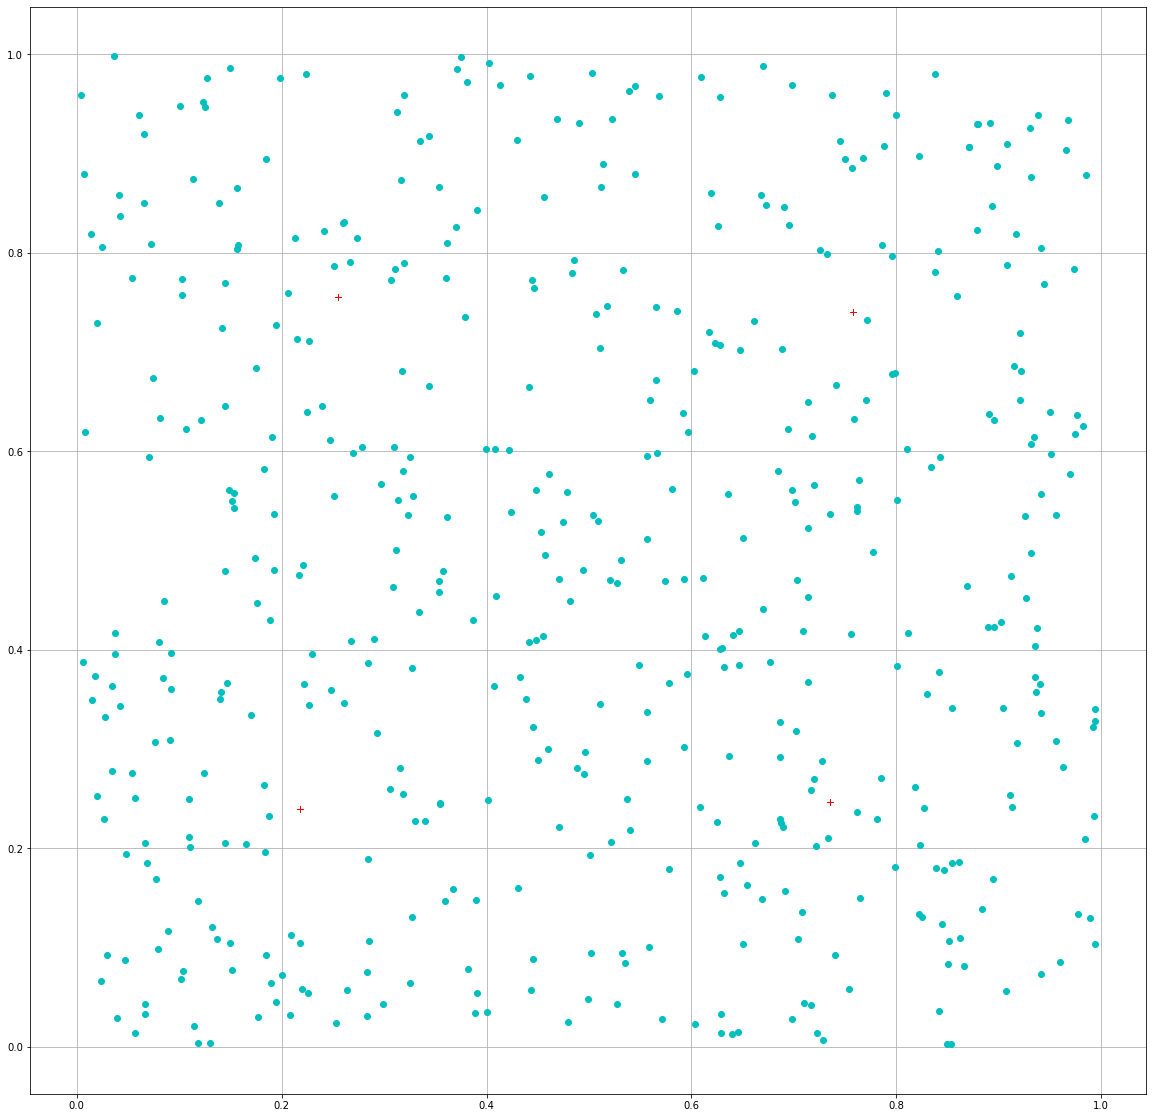

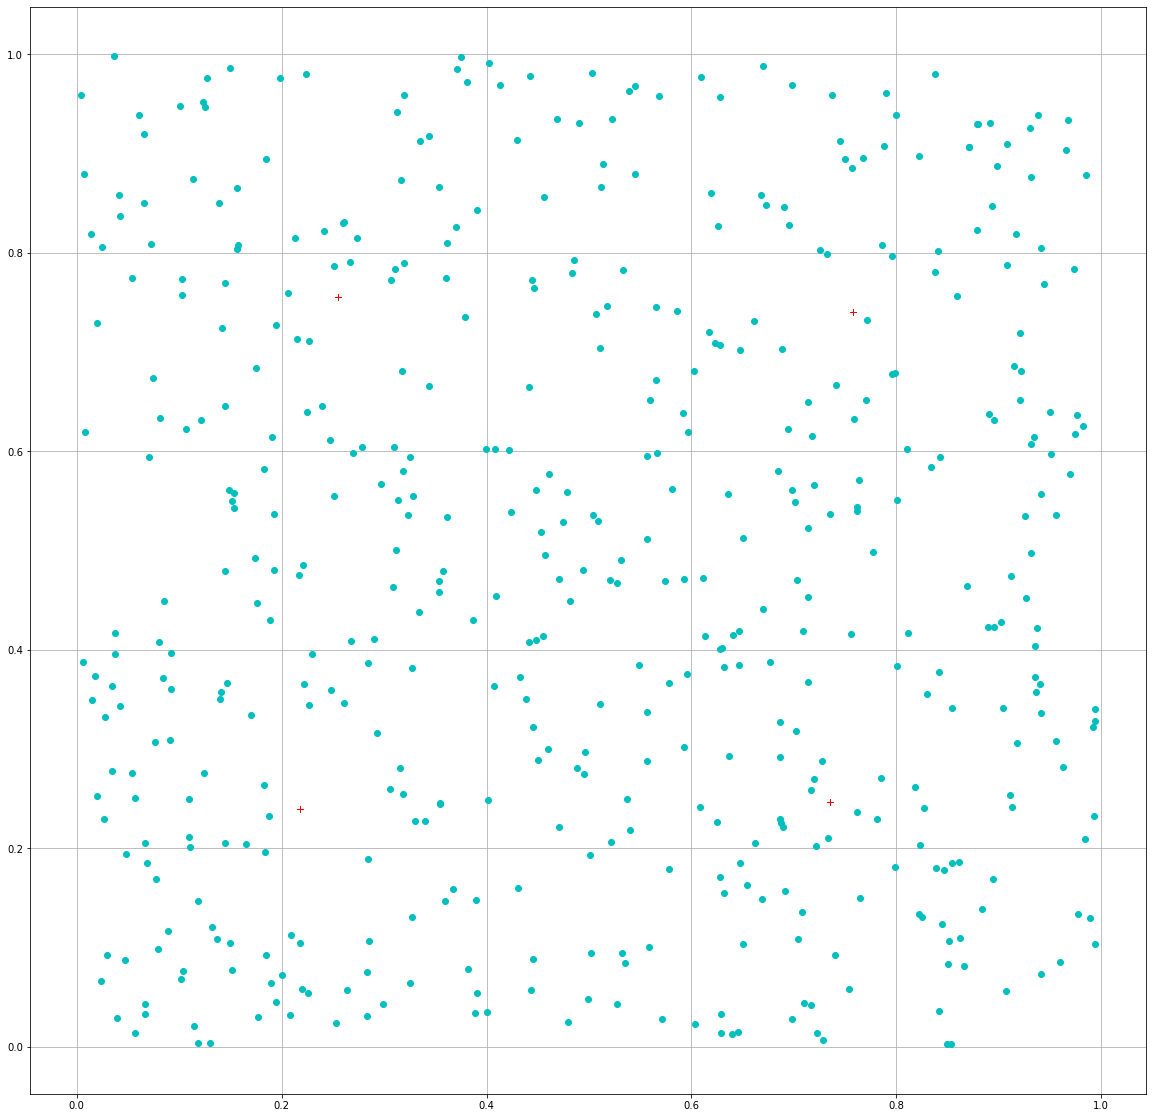

In [3]:
xc_1_ = [0,1]
for k in range(10000):
        #-------------------------------------------------------------------------------------------------------------------------------------------------

    


    

    


    plt.figure(figsize=(20,20))
    plt.grid()
    points1_ =[]
    points2_ =[]
    points3_ =[]
    points4_ =[]
    points5_ =[]
    points6_ =[]
    points7_ =[]
    points8_ =[]
    
    
    dist1 = [] # list of distances from centroid 1 to dataset points
    dist2 = [] # list of distances from centroid 2 to dataset points
    dist3 = [] # list of distances from centroid 3 to dataset points
    dist4 = [] # list of distances from centroid 4 to dataset points
    dist5 = [] # list of distances from centroid 5 to dataset points
    dist6 = [] # list of distances from centroid 6 to dataset points
    dist7 = [] # list of distances from centroid 7 to dataset points
    dist8 = [] # list of distances from centroid 8 to dataset points
    

    for i in range(len(generating_points)):
        dist_1 = ((x[i] - xc_1)**2 + (y[i]-yc_1)**2)**(1/2)
        dist_2 = ((x[i] - xc_2)**2 + (y[i] - yc_2)**2)**(1/2)
        dist_3= ((x[i] - xc_3)**2 + (y[i] - yc_3)**2)**(1/2)
        dist_4 = ((x[i] - xc_4)**2 + (y[i] - yc_4)**2)**(1/2)
       
        


        dist1.append(dist_1)
        dist2.append(dist_2)
        dist3.append(dist_3)
        dist4.append(dist_4)
       

        sum1 = [0,0]
        sum2 = [0,0]
        sum3 = [0,0]
        sum4 = [0,0]
        
       

        count1 = 1
        count2 = 1
        count3 = 1
        count4 = 1
     
        count1_ = []
        count2_ = []
        count3_ = []
        count4_ = []
       
    for i in range(N):
        #----------The logical explain above was implementing in this part below--------------------#

        if(dist1[i]<dist2[i] and dist1[i]<dist3[i] and dist1[i]<dist4[i]):



            plt.plot(x[i],y[i],'co')
            plt.plot(xc_1,yc_1,'r+')
            plt.plot(xc_2,yc_2,'r+')
            plt.plot(xc_3,yc_3,'r+')
            plt.plot(xc_4,yc_4,'r+')
          

            sum1[0] = sum1[0] + x[i]
            sum1[1] = sum1[1] + y[i]
            count1 = count1 + 1
            count1_.append(count1)
            points1_.append([x[i],y[i]])
        elif(dist2[i]<dist1[i] and dist2[i]<dist3[i] and dist2[i]<dist4[i]):

            plt.plot(x[i],y[i],'co')
            plt.plot(xc_1,yc_1,'r+')
            plt.plot(xc_2,yc_2,'r')
            plt.plot(xc_3,yc_3,'r+')
            plt.plot(xc_4,yc_4,'r+')
         
            sum2[0] = sum2[0] + x[i]
            sum2[1] = sum2[1] + y[i]

            count2 = count2 + 1
            count2_.append(count2)
            points2_.append([x[i],y[i]])
        elif(dist3[i]<dist1[i] and dist3[i]<dist2[i] and dist3[i]<dist4[i]):
            plt.plot(x[i],y[i],'co')
            plt.plot(xc_1,yc_1,'r+')
            plt.plot(xc_2,yc_2,'r+')
            plt.plot(xc_3,yc_3,'r+')
            plt.plot(xc_4,yc_4,'r+')
          
            
            sum3[0] = sum3[0] + x[i]
            sum3[1] = sum3[1] + y[i]

            count3 = count3 + 1
            count3_.append(count3)
            points3_.append([x[i],y[i]])
        elif(dist4[i]<dist1[i] and dist4[i]<dist2[i] and dist4[i]<dist3[i]):
            plt.plot(x[i],y[i],'co')
            plt.plot(xc_1,yc_1,'r+')
            plt.plot(xc_2,yc_2,'r+')
            plt.plot(xc_3,yc_3,'r+')
            plt.plot(xc_4,yc_4,'r+')
           

            sum4[0] = sum4[0] + x[i]
            sum4[1] = sum4[1] + y[i]

            count4 = count4 + 1
            count4_.append(count4)
            points4_.append([x[i],y[i]])
        
    xc_1 = sum1[0]/(count1-1) # pois começamos em 1 a lista count para evitar problemas de 'index out of range'
    yc_1 = sum1[1]/(count1-1)

    xc_2 = sum2[0]/(count2-1)
    yc_2 = sum2[1]/(count2-1)

    xc_3 = sum3[0]/(count3-1)
    yc_3 = sum3[1]/(count3-1)

    xc_4 = sum4[0]/(count4-1)
    yc_4 = sum4[1]/(count4-1)

  





    xc_1_.append(xc_1)
    
    if(xc_1_[k+1] == xc_1_[k]):
        break

    #------------------------------------------------------------------------------------------------------------------------------------

We have the 4 best centroids with <b>(xc_i,yc_i)</b> is the coordinate of <b>centroid i</b>. We put together this coordinate in a one variable that called <b>point</b> that represent the <b>centroid i.

In [4]:
point1 = [xc_1,yc_1]
point2 = [xc_2,yc_2]
point3 = [xc_3,yc_3]
point4 = [xc_4,yc_4]


print(point1,point2,point3,point4)

[0.7572638104307323, 0.7405090511413782] [0.2183039559211861, 0.2390044235566654] [0.7352761472535845, 0.24639027991614298] [0.2550303180799479, 0.7558873652766084]


 Now we have to given a weight parameter of each point of each sample. The points that are locate nearest respectively cluster´s centroid has a high weight than the points that are locate away.
. We are going to use the forms that we wrote in the begin of this section, that assume weight´s being $ w(x) = \frac{n}{k} \times \frac{s_{tot}}{s(x)}$. In this case our s(x) is a function of distance each point x to centroid. Because of this we need calculate the distances from each point of each cluster to each centroid of each cluster. We make this on cell bellow.


In [5]:

dist1_ = []
dist2_ = []
dist3_ = []
dist4_ = []



#---------------------- Calculate the distances from each point to each centroid -------------------

#----------Pontos1------------------
for i in range(len(points1_)):
    dist1_.append( ((point1[0] - points1_[i][0])**2 + (point1[1] - points1_[i][1])**2)**(0.5) )
    
#----------Pontos2------------------
for i in range(len(points2_)):
    dist2_.append( ((point2[0] - points2_[i][0])**2 + (point2[1] - points2_[i][1])**2)**(0.5) )
#----------Pontos3------------------
for i in range(len(points3_)):
    dist3_.append( ((point3[0] - points3_[i][0])**2 + (point3[1] - points3_[i][1])**2)**(0.5) )
#----------Pontos4------------------
for i in range(len(points4_)):
    dist4_.append( ((point4[0] - points4_[i][0])**2 + (point4[1] - points4_[i][1])**2)**(0.5) )



    

In [6]:
#----------------------------------------------Weights Distribution------------------------------------------------------------

#----------------- Pontos1---------------------------------
w1 = []
sumdist1 = 0
k=4
for i in range(len(points1_)):
    sumdist1 = sumdist1 + dist1_[i]
    w1.append((sumdist1/dist1_[i])*(len(dist1_)/k))
    

#----------------- Pontos2---------------------------------
w2 = []
sumdist2 = 0
k=4
for i in range(len(points2_)):
    sumdist2 = sumdist2 + dist2_[i]
    w2.append((sumdist1/dist2_[i])*(len(dist2_)/k))
    

#----------------- Pontos3---------------------------------
w3 = []
sumdist3 = 0
k=4
for i in range(len(points3_)):
    sumdist3 = sumdist3 + dist3_[i]
    w3.append((sumdist3/dist3_[i])*(len(dist3_)/k))
    

#----------------- Pontos4---------------------------------
w4 = []
sumdist4 = 0
k=4
for i in range(len(points4_)):
    sumdist4 = sumdist4 + dist4_[i]
    w4.append((sumdist4/dist4_[i])*(len(dist4_)/k))
    



The high weights correponds for a short distances. As Grover´s Algorithm search minimum values, we will search the minimum distance instead maximum weights.

The cell Below, has 4 lists that was called <b>distrdi_</b> that i is a centroid number and distrd means round distance. To construct coresets we consider round distances from the points to centroid that have a value 0.0. Because this points possess a high weight and can make a better representation for our problem.

In [7]:
distrd1_ = []
distrd2_ = []
distrd3_ = []
distrd4_ = []


for i in range(len(dist1_)):
    distrd1_.append(round(dist1_[i],1))
for i in range(len(dist2_)):
    distrd2_.append(round(dist2_[i],1))
for i in range(len(dist3_)):
    distrd3_.append(round(dist3_[i],1))
for i in range(len(dist4_)):
    distrd4_.append(round(dist4_[i],1))

 

print(distrd1_.count(0.0),distrd1_.count(0.1),distrd1_.count(0.2),distrd1_.count(0.3),distrd1_.count(0.4),distrd1_.count(0.5),distrd1_.count(0.6),distrd1_.count(0.7),distrd1_.count(0.8),distrd1_.count(0.9),distrd1_.count(1.0))
print(distrd2_.count(0.0),distrd2_.count(0.1),distrd2_.count(0.2),distrd2_.count(0.3),distrd2_.count(0.4),distrd2_.count(0.5),distrd2_.count(0.6),distrd2_.count(0.7),distrd2_.count(0.8),distrd2_.count(0.9),distrd2_.count(1.0))
print(distrd3_.count(0.0),distrd3_.count(0.1),distrd3_.count(0.2),distrd3_.count(0.3),distrd3_.count(0.4),distrd3_.count(0.5),distrd3_.count(0.6),distrd3_.count(0.7),distrd3_.count(0.8),distrd3_.count(0.9),distrd3_.count(1.0))
print(distrd4_.count(0.0),distrd4_.count(0.1),distrd4_.count(0.2),distrd4_.count(0.3),distrd4_.count(0.4),distrd4_.count(0.5),distrd4_.count(0.6),distrd4_.count(0.7),distrd4_.count(0.8),distrd4_.count(0.9),distrd4_.count(1.0))




1 28 63 28 0 0 0 0 0 0 0
2 30 70 27 0 0 0 0 0 0 0
7 32 64 35 0 0 0 0 0 0 0
3 29 57 24 0 0 0 0 0 0 0


 Look of numbers cells´s return above, in the fist line we have the distance´s group of the centroid1, in the second line we have the distance´s group of the centroid2, and so on.  We might taken the first collumn to ilustrate our problem. Because this quantity of points represents better our data than other points. So let´s taken this first column. And put in a lists, creates in the cell below calleds <i>coreseti</i> where i is a number that represent what the centroid we are studying.
    

In [8]:
#-------------------------------------Each coreset´s point--------------------------------------------
coreset1 = []
coreset2 = []
coreset3 = []
coreset4 = []


for i in range(len(points1_)):
    if(distrd1_[i] == 0.0):
        coreset1.append(points1_[i])
        
    
    
 
for i in range(len(points2_)):
    if(distrd2_[i] == 0.0):
        coreset2.append(points2_[i])
    
    

for i in range(len(points3_)):
    if(distrd3_[i] == 0.0):
        coreset3.append(points3_[i])
    
    
  
for i in range(len(points4_)):
    if(distrd4_[i] == 0.0):
        coreset4.append(points4_[i])
    

    
        
    


In the next cell we taken the all points in coresets and put all together on the list called <i>plotcor</i>.

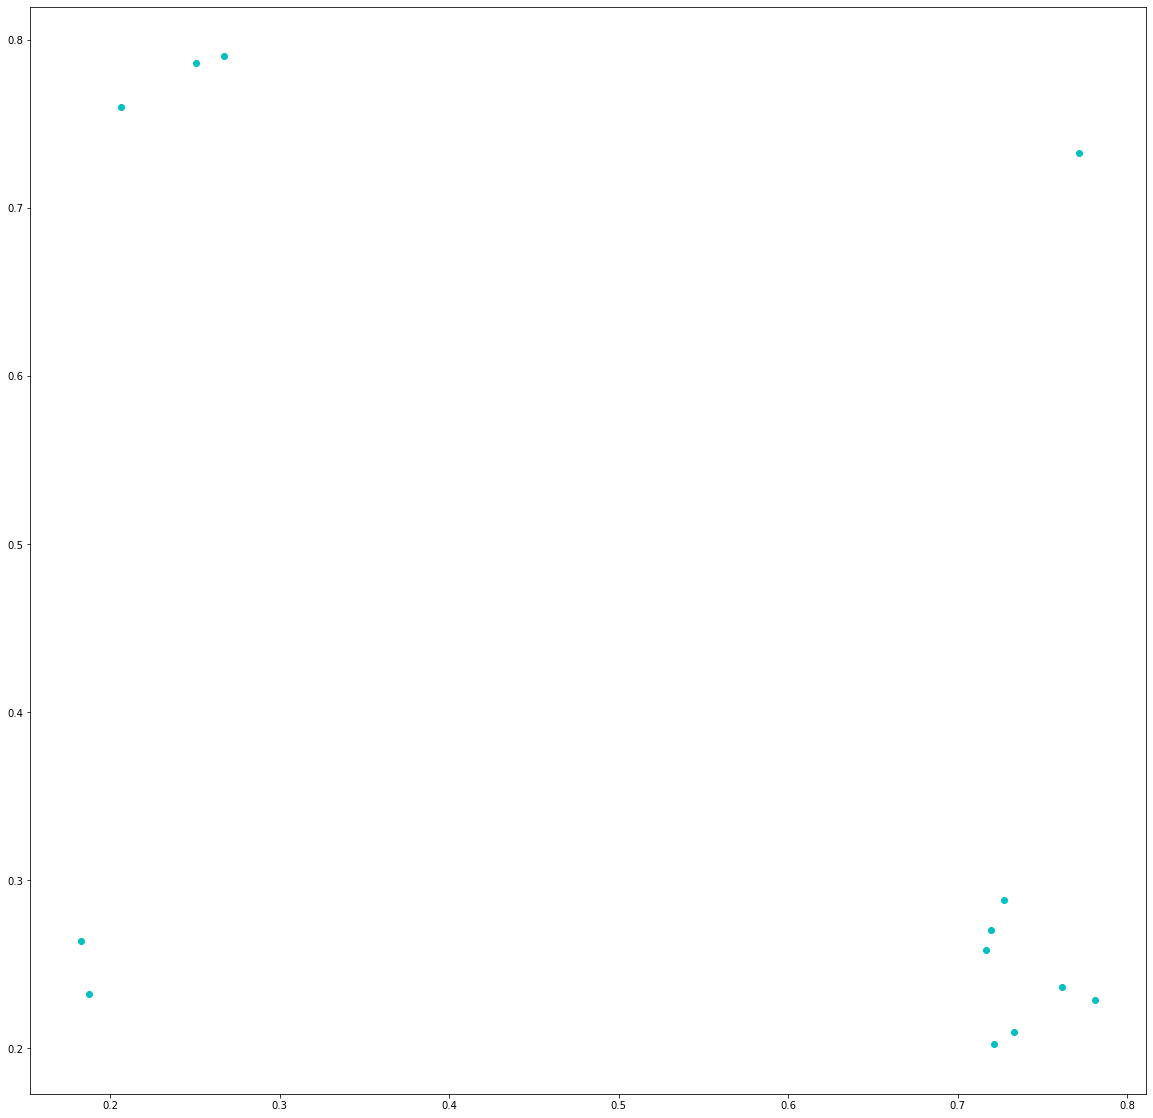

In [9]:
plt.figure(figsize=(20,20))
plotcor = []
for i in range(len(coreset1)):
    plotcor.append(coreset1[i])
for i in range(len(coreset2)):   
    plotcor.append(coreset2[i])
for i in range(len(coreset3)):    
    plotcor.append(coreset3[i])
for i in range(len(coreset4)):    
    plotcor.append(coreset4[i])

for i in range(len(plotcor)):
    plt.plot(plotcor[i][0],plotcor[i][1],'co')


We got generate our offline coresets!
Now, we are alerady to solver k-means clustering problem with grover help


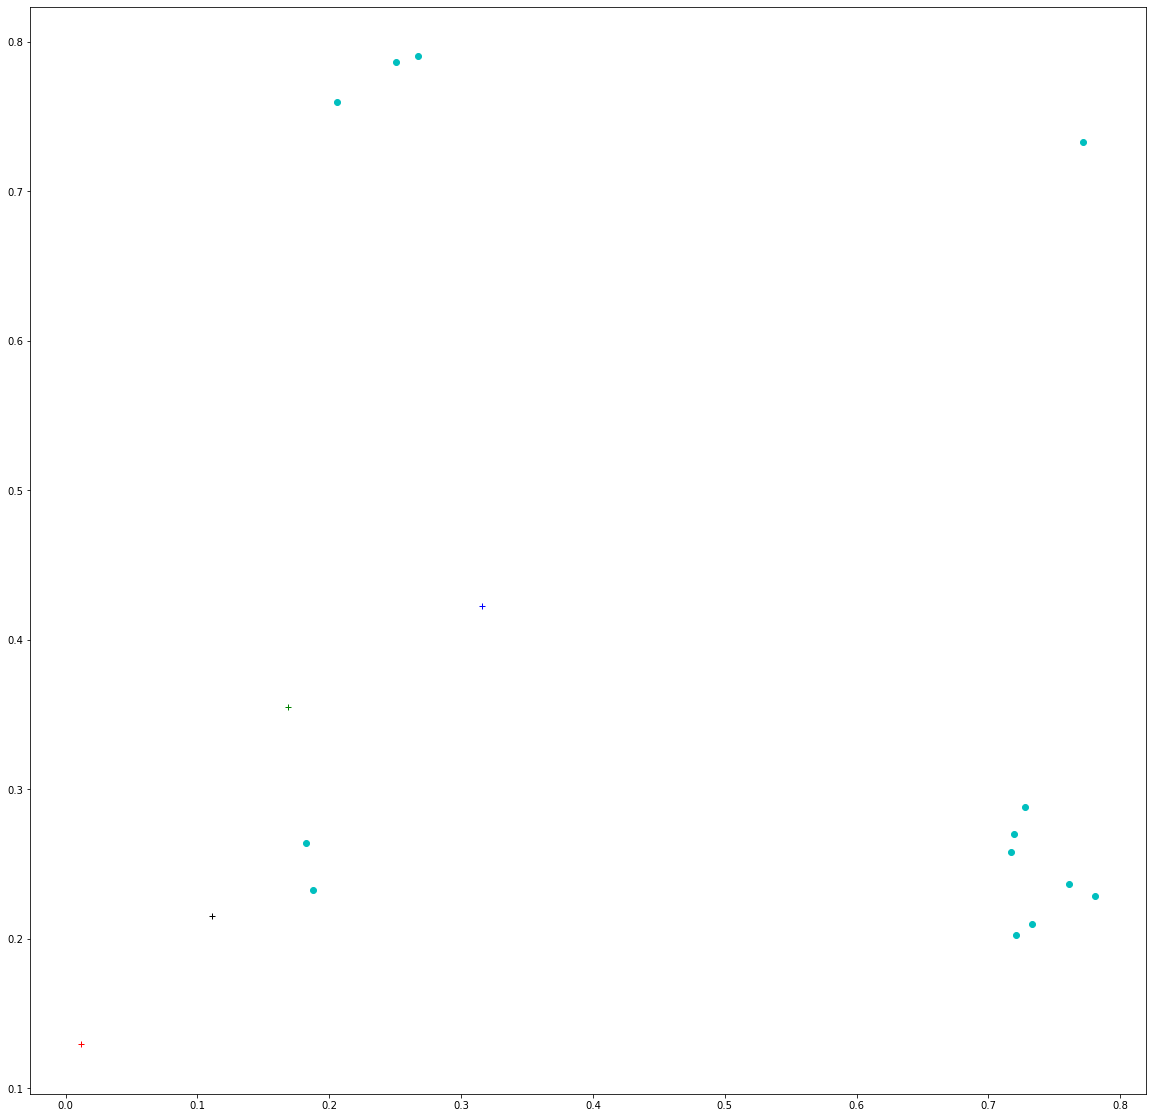

In [10]:


    plt.figure(figsize=(20,20))
    pontob_1 = []
    pontok_2 = []
    pontom_3 = []
    pontog_4 = []
 

    xc_1 =random.random()# generate a random cordinate x for centroid 1 
    yc_1=random.random() # generate a random cordinate y for centroid 1
    pontob_1.append([xc_1,yc_1])
    plt.plot(pontob_1[0][0],pontob_1[0][1],'r+') # plot centroid on the graph 


    #-------------------------------------------------------------------
    xc_2 =random.random() # generate a random cordinate x for centroid 2  
    yc_2=random.random()  # generate a random cordinate y for centroid 2
    pontok_2.append([xc_2,yc_2])
    plt.plot(pontok_2[0][0],pontok_2[0][1],'g+') # plot centroid on the graph 

    #-------------------------------------------------------------------

    xc_3 =random.random()# generate a random cordinate x for centroid 3
    yc_3=random.random() # generate a random cordinate y for centroid 3
    pontom_3.append([xc_3,yc_3])
    plt.plot(pontom_3[0][0],pontom_3[0][1],'b+')  #plot centroid on the graph 




    #-------------------------------------------------------------------
    xc_4 =random.random() # generate a random cordinate x for centroid 4
    yc_4=random.random() # generate a random cordinate y for centroid 4
    pontog_4.append([xc_4,yc_4])
    plt.plot(pontog_4[0][0],pontog_4[0][1],'k+')  #plot centroid on the graph 

    


    for i in range(len(plotcor)):
        plt.plot(plotcor[i][0],plotcor[i][1],'co')



In [11]:
def distances(centroid0, centroid1,centroid2, centroid3):

    dist1__ = []
    dist2__ = []
    dist3__ = []
    dist4__ = []
   

    cost_list = []
    
    


    for i in range(1):
        dist1__.append( ((centroid0[0] - plotcor[i][0])**2 + (centroid0[1] - plotcor[i][1])**2)**(0.5) )

    for i in range(1):
        dist2__.append( ((centroid1[0] - plotcor[i][0])**2 + (centroid1[1] - plotcor[i][1])**2)**(0.5) )

    for i in range(1):
        dist3__.append( ((centroid2[0] - plotcor[i][0])**2 + (centroid2[1] - plotcor[i][1])**2)**(0.5) )

    for i in range(1):
        dist4__.append( ((centroid3[0] - plotcor[i][0])**2 + (centroid3[1] - plotcor[i][1])**2)**(0.5) )



        
    dist1_rd = [] # distance from each point to centroid 1
    dist2_rd = [] # distance from each point to centroid 2
    dist3_rd = [] # distance from each point to centroid 3
    dist4_rd = [] # distance from each point to centroid 4
   

    cost_list = []

    for i in range(len(dist1__)):
        dist1_rd.append(round(dist1__[i]*1000))
        cost_list.append(dist1_rd[0])


    for i in range(len(dist2__)):
        dist2_rd.append(round(dist2__[i]*1000))
        cost_list.append(dist2_rd[0])


    for i in range(len(dist3__)):
        dist3_rd.append(round(dist3__[i]*1000))
        cost_list.append(dist3_rd[0])


    for i in range(len(dist4__)):
        dist4_rd.append(round(dist4__[i]*1000))
        cost_list.append(dist4_rd[0])




    return cost_list

In [12]:
plotcor

[[0.7716527624032109, 0.73256812173484],
 [0.18269502277152594, 0.2640021407803803],
 [0.18735445831848674, 0.23240045792896125],
 [0.7169635673025858, 0.258341892724122],
 [0.7812906145123598, 0.2288966232520805],
 [0.7614678285868938, 0.2364421975981117],
 [0.7329595642070358, 0.20976489298390844],
 [0.7196031512001765, 0.2701829669081408],
 [0.7212506252527415, 0.2022496904384533],
 [0.7274480771489941, 0.28826159586482114],
 [0.20605459417427185, 0.7598273330263363],
 [0.26701272451442293, 0.7903255380690681],
 [0.25077580109487196, 0.7863630167542376]]

### Grover's Algorithm to find mininum

In order to use Grover's Algorithm to find a mininum in a classical data set, one proposal is to use a “quantum RAM,” typically meaning a large classical memory which can be queried in superposition [1]. It can be easily builded using an equivalent quantum circuit which classical data is stored in a quantum register. In this application, classical data would be the Euclidean distances between each point of the coreset and the k-means centroids. So, if there are $k$ centroids, there are $k$ distances stored in the Quantum RAM. The image bellow represents a quantum circuit equivalent to a qRAM where each Euclidean distance $x_j$ is indexed by $j$.

<img src="files/qram.png" width="800" height="400">

The full quantum circuit for Grover's Algorithm is showed in the figure bellow.

<img src="files/grover.png" width="800" height="400">

Phase flip is an iterative function which analise the most significant qubits of the measured value and apply phase inversion on the distances which are smaller than the measured value. In order to make it more clear, let's see an example on how it works. 

Let's suppose $distances = [9,5,19,20,17,22,23,29,31,44,52,55,57,73,4,12,125,48,56,33,22,77,48,54,50,122,111,31,32,69,93,97,94,101,105,110,111,126,127,22,33,44,55,66,77,88,99,100,11123,43,54,65,76,87,98,7,6,8,11,63]$. If we measure randomly 125 = 0b1111101, we know that if we apply the phase inversion in all states that contains '0' (0b0______) in the most significant qubit, all these marked states will have decimal values less than the measured value 125. We can mark all states with a single operation, due to the superposition of states in Quantum RAM. The Diffuser operator $U = 2|\phi\rangle \langle \phi| - 1 $ will act in this state performing an inversion about the mean, increasing the probability to measure one of these marked states (with equal probability). If the next measured value is i.e. 12 = 0b0001100, we must mark states all states such that the four most signicant qubits are '0' (0b0000___). Then, after measurement, possible measured values are 4 and 5. If we measure 5 = 0b0000101, we search for states which has this binary representation: 0b00000__ but when we measure probably we'll measurea number greater than 5 because there is no numbers like 0b00000__ so it means that the mininum is between $5$ and $2^2$. Let's see, in the figure bellow, how we can perform the iterative phase flip function. This logic can be used for any data sets.

<img src="files/phaseflip.png" width="800" height="400">

For each iteration Grover's perform $\sqrt N$ iterations. So, it takes time $O(c \sqrt N) \equiv O(\sqrt N) $ where $c$ is, in the worst case, the number of bits of the first measured value. 



### Implementing with Qiskit

In [33]:
def Grover():
    
 
                
    
    
    
    reg1 = 3 #stores indexes values 'j'
    reg2 = 11 #stores T(j) generating sum |j>|T(j)>
    
    aux = 1 #ancilla
    n = reg1+reg2+aux
    
    def qram():
        #cost_list = []
        mem = QuantumCircuit(n)
        
        mem.x([0,1,2])
        for i in range(reg2):
            if(T[0][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([0,1,2])
        mem.barrier()

        mem.x([0,1])
        for i in range(reg2):
            if(T[1][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([0,1])
        mem.barrier()

        
        mem.x([0,2])
        for i in range(reg2):
            if(T[2][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([0,2])
        mem.barrier()

        mem.x([0])
        for i in range(reg2):
            if(T[3][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([0])
        mem.barrier()  

        mem.x([1,2])
        for i in range(reg2):
            if(T[4][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([1,2])
        mem.barrier()


        mem.x([1])
        for i in range(reg2):
            if(T[5][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([1])
        mem.barrier()

        mem.x([2])
        for i in range(reg2):
            if(T[6][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([2])
        mem.barrier()


        for i in range(reg2-1):
            if(T[7][i]==1):
                mem.mct([0,1,2],3+i)





        mem.barrier()
        return mem



    #############################################################


    def diffuser():

        diff = QuantumCircuit(reg1)
        diff.h(range(reg1))
        diff.x(range(reg1))
        diff.h(reg1-1)
        diff.mct([0,1],2)
        diff.h(reg1-1)
        diff.x(range(reg1))
        diff.h(range(reg1))
        diff.barrier()

        return diff
    current_min = np.random.choice(distt)
    pos = distt.index(current_min)
    control=[]
    control2=[]
    count = []
    curr_min = []
    current_min

    for i in range(reg2):
        if(T[pos][i]==0):
            control.append(i+reg1)
            control2.append(i+reg1)
        if(T[pos][i]==1):
            control.append(i+reg1)
            control2.append(i+reg1)
            break
    for i in range(reg2):

        qc=QuantumCircuit(n,reg1)

        # INITIALIZE
        qc.h(range(reg1))
        qc.x(n-1)
        qc.h(n-1)
        qc.barrier()
        # END INITIALIZE


        ################### FIRST GROVER ITERATION ##########################

        # STORES cost_list in reg2
        qc = qc.compose(qram())
        # END STORAGE


        # FLIP PHASE
        qc.x(control2)
        qc.mct(control,n-1)
        qc.x(control2)
        qc.barrier()
        # END FLIP PHASE


        # UNCOMPUTE qRAM
        qc = qc.compose(qram())
        # END UNCOMPUTE


        # DIFFUSER
        qc = qc.compose(diffuser())
        # END DIFFUSER


        '''################### SECOND GROVER ITERATION ##########################


        # STORES cost_list in reg2
        qc = qc.compose(qram())
        # END STORAGE


        # FLIP PHASE
        qc.x(control2)
        qc.mct(control,n-1)
        qc.x(control2)
        qc.barrier()
        # END FLIP PHASE

        # UNCOMPUTE qRAM
        qc = qc.compose(qram())
        # END UNCOMPUTE


        # DIFFUSER
        qc = qc.compose(diffuser())
        # END DIFFUSER

        '''
        ############################# END GROVER ITERATIONS #############################

        # CHANGE ORDER OF QUBITS
        qc.swap(0,2)


        # MEASUREMENT
        qc.measure(range(reg1),range(reg1))

        # EXECUTE
        counts = execute(qc, backend=simulator, shots=1).result().get_counts(qc)

        # BINARY TO DECIMAL
        for measured_value in counts:
            a=int(measured_value[::1], 2)

        
        
        if((distt[a]<current_min) and (len(count)==0)):

            current_min = distt[a]


            control.append(len(control)+reg1)
            control2.append(len(control2)+reg1)

        elif(distt[a]>=current_min):

            count.append(0)

            control.append(len(control)+reg1)

            if(len(count)==1):
                control2[len(control2)-1]=control2[len(control2)-1]+1

            else:
                control2.append(control2[len(control2)-1]+1)

        if(control[len(control)-1]==12):
            break

        curr_min.append(distt[a])

   

    '''cost_list
    print(T)


    print(ind)'''
    mini = min(curr_min)
    print('minimum distance: ',mini)

    return distt.index(mini)  



### Using Grover's Algorithm to find the best clustering

In [34]:
centroid0 = [random.random(), random.random()]
centroid1 = [random.random(), random.random()]
centroid2 = [random.random(), random.random()]
centroid3 = [random.random(), random.random()]

for p in range(5):
    c0 = []
    c1 = []
    c2 = []
    c3 = []

    for t in range(len(plotcor)):


        distt=[]


        # we suppose there is a qRAM where distances are stored
        '''distances(centroid0, centroid1,centroid2, centroid3, centroid4, centroid5, centroid6, centroid7, centroid8, centroid9,
                centroid10,centroid11,centroid12,centroid13,centroid14,centroid15)'''

        #finding minimum distance
        distt.append(round(((centroid0[0] - plotcor[t][0])**2 + (centroid0[1] - plotcor[t][1])**2)**(0.5)*1000))
        distt.append(round( ((centroid1[0] - plotcor[t][0])**2 + (centroid1[1] - plotcor[t][1])**2)**(0.5)*1000))
        distt.append( round (((centroid2[0] - plotcor[t][0])**2 + (centroid2[1] - plotcor[t][1])**2)**(0.5)*1000))
        distt.append( round( ((centroid3[0] - plotcor[t][0])**2 + (centroid3[1] - plotcor[t][1])**2)**(0.5)*1000))
        distt.append(1023)
        distt.append(1022)
        distt.append(1021)
        distt.append(1020)
        
        
        T = []
        for m in range(len(distt)):
            T.append(list(f'{distt[m]:011b}'))
        for m in range(len(T)):
            for n in range(len(T[m])):
                T[m][n] = int(T[m][n])    
        
        print("Euclidian distances:",distt)
        print(t)
        Grover() 

       
        if(Grover()==0):
            c0.append(plotcor[t])

        elif(Grover()==1):
            c1.append(plotcor[t])

        elif(Grover()==2):
            c2.append(plotcor[t])

        elif(Grover()==3):
            c3.append(plotcor[t])


        

       ##########################################################################
        cs = [c0,c1,c2,c3]
        print(cs)
        centroid = [centroid0, centroid1,centroid2, centroid3]

    for j in range(len(cs)):

        sumx = 0
        for k in range(len(cs[j])):
            sumx = sumx + cs[j][k][0]


        sumy = 0
        for k in range(len(cs[j])):
            sumy = sumy + cs[j][k][1]
        try:
            newcentroid = [sumx/len(cs[j]) , sumy/len(cs[j])]
        except IOError:
            continue
        except ZeroDivisionError:
            continue


        centroid[j] = newcentroid
        print(newcentroid)
        
    ################################################################################

    
    print('\n')
    print(centroid) 
    print( distt)


Euclidian distances: [698, 1016, 623, 833, 1023, 1022, 1021, 1020]
0
minimum distance:  623
minimum distance:  623
minimum distance:  623
minimum distance:  698
minimum distance:  623
[[], [], [], []]
Euclidian distances: [624, 942, 555, 761, 1023, 1022, 1021, 1020]
1
minimum distance:  555
minimum distance:  555
minimum distance:  555
minimum distance:  624
minimum distance:  555
[[], [], [], []]
Euclidian distances: [666, 994, 624, 793, 1023, 1022, 1021, 1020]
2
minimum distance:  624
minimum distance:  624
minimum distance:  624
minimum distance:  624
[[], [], [[0.7918253806083887, 0.7409844447321745]], []]
Euclidian distances: [517, 652, 195, 678, 1023, 1022, 1021, 1020]
3
minimum distance:  195
minimum distance:  195
minimum distance:  195
minimum distance:  195
[[], [], [[0.7918253806083887, 0.7409844447321745], [0.18771303627924196, 0.764238856207504]], []]
Euclidian distances: [456, 594, 133, 616, 1023, 1022, 1021, 1020]
4
minimum distance:  133
minimum distance:  133
minimum d